Reference: <br>
https://github.com/rapidsai/cuml/blob/branch-0.17/notebooks/arima_demo.ipynb

# ARIMA
An AutoRegressive Integrated Moving Average model is used in time series analysis to understand the data or forecast future points.

This implementation can fit a model to each time series in a batch and perform in-sample predictions and out-of-sample forecasts. It is designed to give the best performance when working on a large batch of time series.

Useful links:
- [cuDF documentation](https://docs.rapids.ai/api/cudf/stable)
- [cuML's ARIMA API docs](https://docs.rapids.ai/api/cuml/stable/api.html#arima)
- [Introduction to ARIMA](https://otexts.com/fpp2/arima.html)

## Imports

In [1]:
import cudf
from cuml.tsa.arima import ARIMA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Loading Util
The data is stored in CSV format:

- data series stored in columns
- first column contains date of data points
- first row contains name of each variable

<i>Population estimate</i> dataset with discarded date, and limited batch size for convenience:

In [ ]:
# def load_dataset(name, max_batch=4):
#     import os
#     pdf = pd.read_csv(os.path.join("data", "time_series", "%s.csv" % name))
#     return cudf.from_pandas(pdf[pdf.columns[1:max_batch+1]].astype(np.float64))

In [2]:
url = 'https://raw.githubusercontent.com/rapidsai/cuml/branch-0.17/notebooks/data/time_series/population_estimate.csv'

pdf = pd.read_csv(url)
max_batch = 4

df = cudf.from_pandas(pdf[pdf.columns[1:max_batch+1]].astype(np.float64))

In [3]:
df

,Male,Female
0,238.1,183.2
1,250.4,194.2
2,252.5,201.6
3,264.6,211.5
4,281.8,225.5
...,...,...
132,2083.4,2169.2
133,2104.1,2187.4
134,2134.0,2213.2
135,2158.2,2234.9


# Visualization Util
Define a helper function that displays the data, and optionally a prediction starting from a given index.

Each time series is plot separately for better readability.

In [4]:
def visualize(y, pred=None, pred_start=None, lower=None, upper=None):
    # (rows, columns)
    n_obs, batch_size = y.shape
    col = ["#1f77b4", "#ff7f0e"]

    # Create the subplots
    c = min(batch_size, 2) # ncols
    r = (batch_size + c - 1) // c # nrows

    # No squeezing
    # Returned Axes object is a 2D array containing Axes instances, even if it ends up being 1x1
    fig, ax = plt.subplots(r, c, squeeze=False)
    # Flattens ax from the Axes group of n*m to the 1*nm Axes group
    ax = ax.flatten()
    
    # Range for the prediction
    if pred is not None:
        pred_start = pred_start or n_obs
        pred_end = pred_start + pred.shape[0]
    
    # Plot the data
    for i in range(batch_size):
        title = y.columns[i]
        ax[i].plot(np.r_[:n_obs], y[title].to_array(), color=col[0])

        if pred is not None:
            ax[i].plot(np.r_[pred_start:pred_end],
                       pred[pred.columns[i]].to_array(),
                       linestyle="--", color=col[1])
            
        # Prediction intervals
        if lower is not None and upper is not None:
            ax[i].fill_between(np.r_[pred_start:pred_end],
                               lower[lower.columns[i]].to_array(),
                               upper[upper.columns[i]].to_array(),
                               alpha=0.2, color=col[1])
        
        ax[i].title.set_text(title)
    
    for i in range(batch_size, r*c):
        fig.delaxes(ax[i])
    
    fig.tight_layout()
    plt.show()

# Non-seasonal ARIMA Models
Basic `ARIMA(p,d,q)` model is made of 3 components:
- **Integrated** (I): series is differenced d times until it is stationary
- **AutoRegressive** (AR): variable is regressed on its p past values
- **Moving Average** (MA): variable is regressed on q past error terms

The model can also incorporate an optional constant term (intercept).

## A Simple MA(2) Example
Start with a simple Moving Average model.
<br>
Load and visualize the <i>migrations in Auckland by age</i> dataset:

/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(


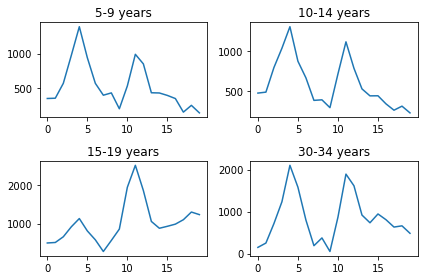

In [5]:
url = 'https://raw.githubusercontent.com/rapidsai/cuml/branch-0.17/notebooks/data/time_series/net_migrations_auckland_by_age.csv'

pdf = pd.read_csv(url)
max_batch = 4

df_mig = cudf.from_pandas(pdf[pdf.columns[1:max_batch+1]].astype(np.float64))

# df_mig = load_dataset("net_migrations_auckland_by_age", 4)
visualize(df_mig)

Fit model with `q`=2 and with an intercept.

`ARIMA` class accepts cuDF dataframes or array-like types as input (host or device), e.g numpy arrays.

We already have a dataframe so pass it to the `ARIMA` constructor with the model parameters:

In [6]:
model_mig = ARIMA(df_mig, (0,0,2), fit_intercept=True)
model_mig.fit()

/tmp/ipykernel_53/1254525407.py:1: FutureWarning: Pass order=(0, 0, 2) as keyword args. From version 21.06, passing these as positional arguments will result in an error
  model_mig = ARIMA(df_mig, (0,0,2), fit_intercept=True)


ARIMA()

Forecast and visualize the results:

/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/

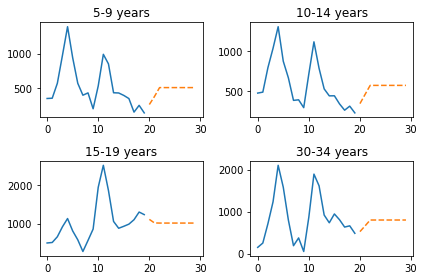

In [7]:
fc_mig = model_mig.forecast(10)

visualize(df_mig, fc_mig)

If want to get the parameters that were fitted to the model, use `get_fit_params()` or the corresponding properties.

The parameters are organized in 2D arrays: <br>
one row represents one parameter and the columns are different batch members.

In [8]:
print(model_mig.get_fit_params()["ma"])
print('-------')
print(model_mig.ma_)

          0        1         2         3
0  0.999900  0.99990  0.999900  0.999900
1  0.546462  0.64176  0.570556  0.493381
-------
          0        1         2         3
0  0.999900  0.99990  0.999900  0.999900
1  0.546462  0.64176  0.570556  0.493381


It is also possible to get a compact numpy array containing all the parameters with `pack()`, or similarly to load the parameters into a model with `unpack()`:

In [9]:
print(model_mig.pack())

[5.12923772e+02 9.99900000e-01 5.46461681e-01 3.71867966e+04
 5.68205186e+02 9.99900000e-01 6.41759917e-01 4.10081385e+04
 1.01468541e+03 9.99900000e-01 5.70555891e-01 1.24247717e+05
 7.99752423e+02 9.99900000e-01 4.93380775e-01 1.21165891e+05]


We can also get the log-likelihood of the parameters w.r.t to the series, and evaluate various information criteria:

In [10]:
print("log-likelihood:\n", model_mig.llf)
print("\nAkaike Information Criterion (AIC):\n", model_mig.aic)
print("\nCorrected Akaike Information Criterion (AICc):\n", model_mig.aicc)
print("\nBayesian Information Criterion (BIC):\n", model_mig.bic)

log-likelihood:
 [-134.97545687 -133.76443601 -143.15916933 -147.41631188]

Akaike Information Criterion (AIC):
 0    277.950914
1    275.528872
2    294.318339
3    302.832624
dtype: float64

Corrected Akaike Information Criterion (AICc):
 0    280.617580
1    278.195539
2    296.985005
3    305.499290
dtype: float64

Bayesian Information Criterion (BIC):
 0    281.933843
1    279.511801
2    298.301268
3    306.815553
dtype: float64


## An ARIMA(1,2,1) Example
Load <i>population estimate</i> dataset.

For this dataset, a first difference is not enough to make the data stationary because of the quadratic trend, so let `d`=2.

Forecast and predict in-sample:

/tmp/ipykernel_53/2459810068.py:12: FutureWarning: Pass order=(1, 2, 1) as keyword args. From version 21.06, passing these as positional arguments will result in an error
  model_pop = ARIMA(df_pop, (1,2,1), fit_intercept=True)
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/co

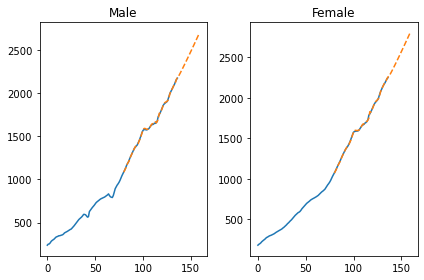

In [11]:
# df_pop = load_dataset("population_estimate")

url = 'https://raw.githubusercontent.com/rapidsai/cuml/branch-0.17/notebooks/data/time_series/population_estimate.csv'

df_pop = pd.read_csv(url)
max_batch = 4

df_pop = cudf.from_pandas(df_pop[df_pop.columns[1:max_batch+1]].astype(np.float64))


# Fit an ARIMA(1,2,1) model
model_pop = ARIMA(df_pop, (1,2,1), fit_intercept=True)
model_pop.fit()

# Predict in-sample and forecast out-of-sample
pred_pop = model_pop.predict(80, 160)
visualize(df_pop, pred_pop, 80)

### Confidence intervals
To get confidence intervals when forecasting, specify the confidence level (here 95%):

/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/

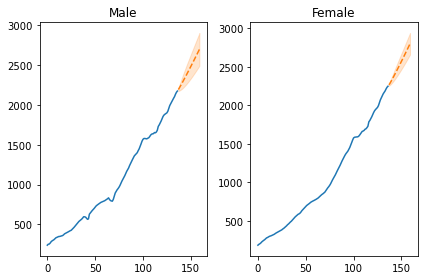

In [12]:
fc_pop, lower_pop, upper_pop = model_pop.forecast(23, level=0.95)
visualize(df_pop, fc_pop, lower=lower_pop, upper=upper_pop)

# Seasonal ARIMA models
[Seasonal ARIMA models](https://otexts.com/fpp2/seasonal-arima.html) are expressed in the form `ARIMA(p,d,q)(P,D,Q)`s and have additional seasonal components that we denote SAR and SMA.

We can also choose to apply a first or second seasonal difference, or combine a non-seasonal and a seasonal difference (note: `p+P` <= 2 is required).

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.

The m parameter influences the P, D, and Q parameters. For example, an m of 12 for monthly data suggests a yearly seasonal cycle.

## An ARIMA(1,1,1)(1,1,1)12 Example
Load <i>guest nights by region</i> dataset.

This dataset shows a strong seasonal component with a period of 12 (annual cycle, monthly data), and also a non-seasonal trend.

A good choice is to go with `d`=1, `D`=1 and `s`=12.

Create model with seasonal parameters, and forecast:

In [13]:
# df_guests = load_dataset("guest_nights_by_region", 4)

url = 'https://raw.githubusercontent.com/rapidsai/cuml/branch-0.17/notebooks/data/time_series/guest_nights_by_region.csv'

df_guests = pd.read_csv(url)
max_batch = 4

df_guests = cudf.from_pandas(df_guests[df_guests.columns[1:max_batch+1]].astype(np.float64))

# Create and fit an ARIMA(1,1,1)(1,1,1)12 model:
model_guests = ARIMA(df_guests, (1,1,1), (1,1,1,12), fit_intercept=False)
model_guests.fit()

/tmp/ipykernel_53/3607946255.py:11: FutureWarning: Pass order=(1, 1, 1), seasonal_order=(1, 1, 1, 12) as keyword args. From version 21.06, passing these as positional arguments will result in an error
  model_guests = ARIMA(df_guests, (1,1,1), (1,1,1,12), fit_intercept=False)


ARIMA()

/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/

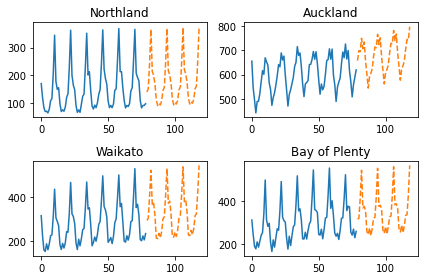

In [14]:
# Forecast
fc_guests = model_guests.forecast(40)

# Visualize after the time step 200
visualize(df_guests[200:], fc_guests)

Note that the model can't form predictions at the start where we padded with missing values. The first in-sample predictions will be equal to a constant value (0 in the absence of intercept).

# Exogenous Variables
ARIMA also supports exogenous variables. <br>
As this model works with a batch, there are some limitations:
- each column of `endog` corresponds to a fixed number of columns of `exog`
- exogenous variables can't be shared by different series (they have to be duplicated if necessary)
- all series must have the same number of exogenous variables.

The shape of `exog` must be `(n_obs, batch_size * n_exog)`. <br>
Columns are grouped by corresponding batch id. <br>
For predictions and forecasts, values of the exogenous variables for future steps must be provided in an array of shape `(nsteps, batch_size * n_exog)`.

Note that endogenous variables might contain missing observations but exogenous variables cannot.

To illustrate this, again create a fake dataset from the one used above, adding some procedural variables.

In [15]:
nb = 4

# Generate exogenous variables and coefficients
get_sine = lambda n, period: \
    np.sin(np.r_[:n] * 2 * np.pi / period + np.random.uniform(0, period))
np_exog = np.column_stack([get_sine(319, T)
                           for T in np.random.uniform(20, 100, 2 * nb)])
np_exog_coef = np.random.uniform(20, 200, 2 * nb)

# Create dataframes for the past and future values
df_exog = cudf.DataFrame(np_exog[:279])
df_exog_fut = cudf.DataFrame(np_exog[279:])

# Add linear combination of the exogenous variables to the endogenous
df_guests_exog = df_guests.copy()
for ib in range(nb):
    df_guests_exog[df_guests_exog.columns[ib]] += \
        np.matmul(np_exog[:279, ib*2:(ib+1)*2], np_exog_coef[ib*2:(ib+1)*2])

In [16]:
# Create and fit an ARIMA(1,0,1)(1,1,1)12 (c) model with exogenous variables
model_guests_exog = ARIMA(endog=df_guests_exog, exog=df_exog,
                          order=(1,0,1), seasonal_order=(1,1,1,12),
                          fit_intercept=True)
model_guests_exog.fit()

ARIMA()

/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/series.py:1659: FutureWarning: The to_array method will be removed in a future cuDF release. Consider using `to_numpy` instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/rapids-21.12/lib/python3.8/site-packages/cudf/

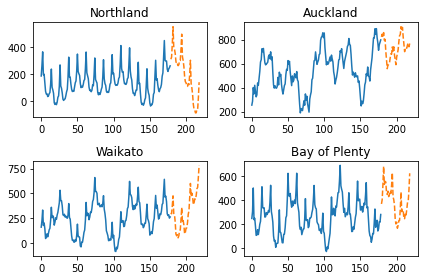

In [17]:
# Forecast
fc_guests_exog = model_guests_exog.forecast(40, exog=df_exog_fut)

# Visualize after the time step 100
visualize(df_guests_exog[100:], fc_guests_exog)